In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from prophet import Prophet
from scipy import stats
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


In [4]:
data = pd.read_excel("owid-covid-data.xlsx")

In [38]:
# Filtering for switzerland
swiss_data = data[data['location'] == 'Switzerland']

# only need date & new_cases
swiss_data = swiss_data[['date', 'new_cases']]

swiss_data.head()



,date,new_cases
295631,2020-01-03,0.0
295632,2020-01-04,0.0
295633,2020-01-05,0.0
295634,2020-01-06,0.0
295635,2020-01-07,0.0


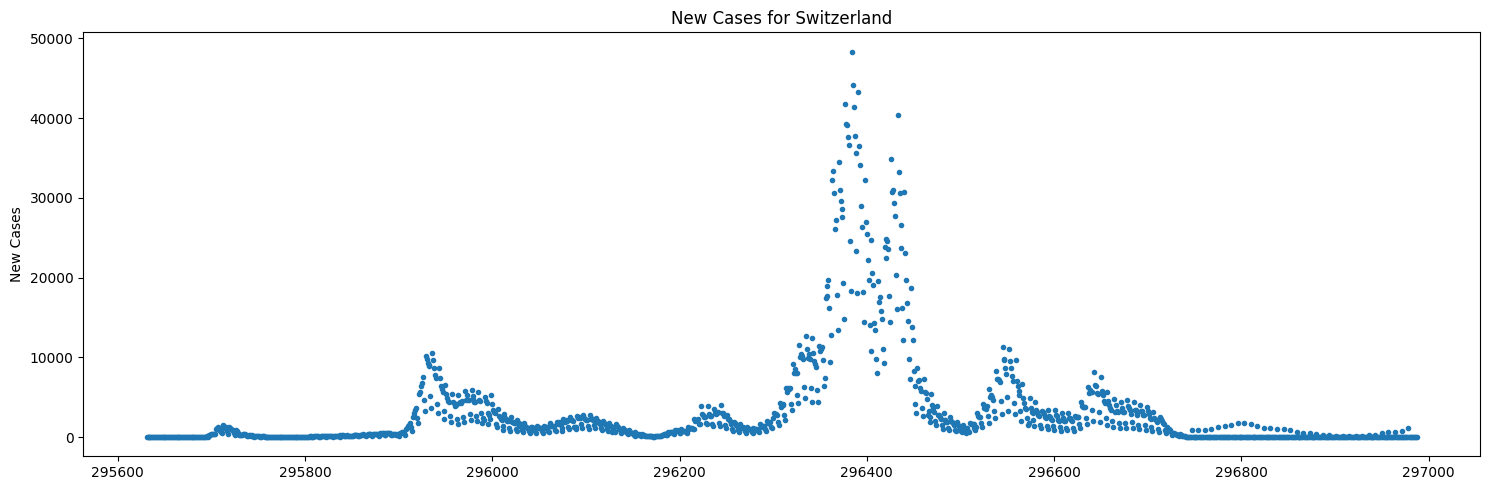

In [39]:
## Plotting Switzerland

plt.figure(figsize=(15, 5))
swiss_data['new_cases'].plot(style='.', title=f'New Cases for Switzerland')
plt.ylabel('New Cases')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

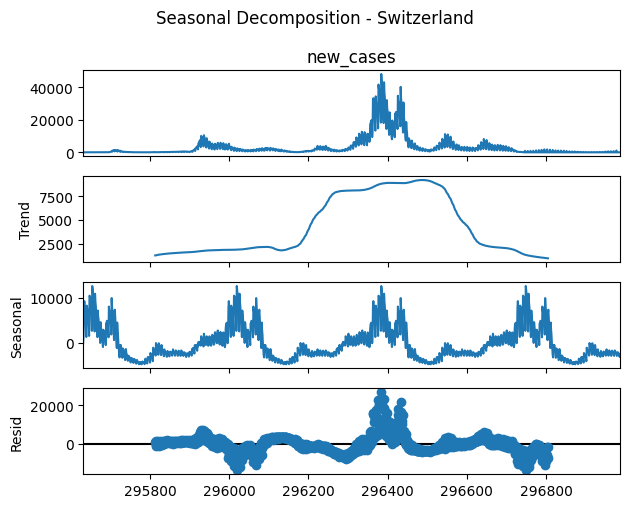

In [41]:
## checking time series decomp
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(swiss_data['new_cases'], period=365)
    
plt.figure(figsize=(10, 6))
    
# Create plots
result.plot()
    
# Set the title with a higher y value to shift it up
plt.suptitle(f'Seasonal Decomposition - Switzerland', y=1.05)
    
# Display the figure
plt.show()

Seasonal trend is additive, not multiplicative.

## Data Prep

In [45]:
# missing values?
missing_values_count_before = swiss_data['new_cases'].isnull().sum()
print(missing_values_count_before)


0


## Prophet 

In [46]:
# rename columns into ds & y
swiss_data = swiss_data.rename(columns={'date': 'ds', 'new_cases': 'y'})



# initialize and fit prophet
m = Prophet()
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(swiss_data)

14:50:25 - cmdstanpy - INFO - Chain [1] start processing
14:50:25 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# setting future dates
future = m.make_future_dataframe(periods=14)
future.tail()



,ds
1366,2023-09-30
1367,2023-10-01
1368,2023-10-02
1369,2023-10-03
1370,2023-10-04


In [10]:
# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
1366,2023-09-30,386.069248,-4402.629894,4982.887123
1367,2023-10-01,-666.942913,-5698.640244,4183.934797
1368,2023-10-02,-918.810573,-5311.429877,3898.945550
1369,2023-10-03,1818.882818,-2876.358289,6693.314408
1370,2023-10-04,1361.000425,-3172.964919,6098.616654


## Plotting Forecast

/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


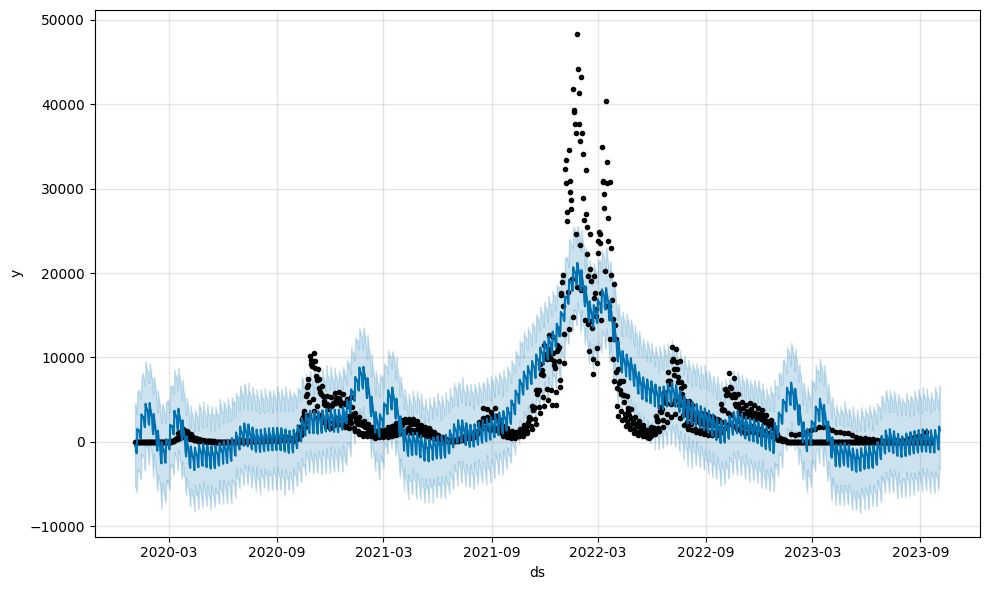

In [11]:
# Python
fig1 = m.plot(forecast)



## Plotting Components

/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of 

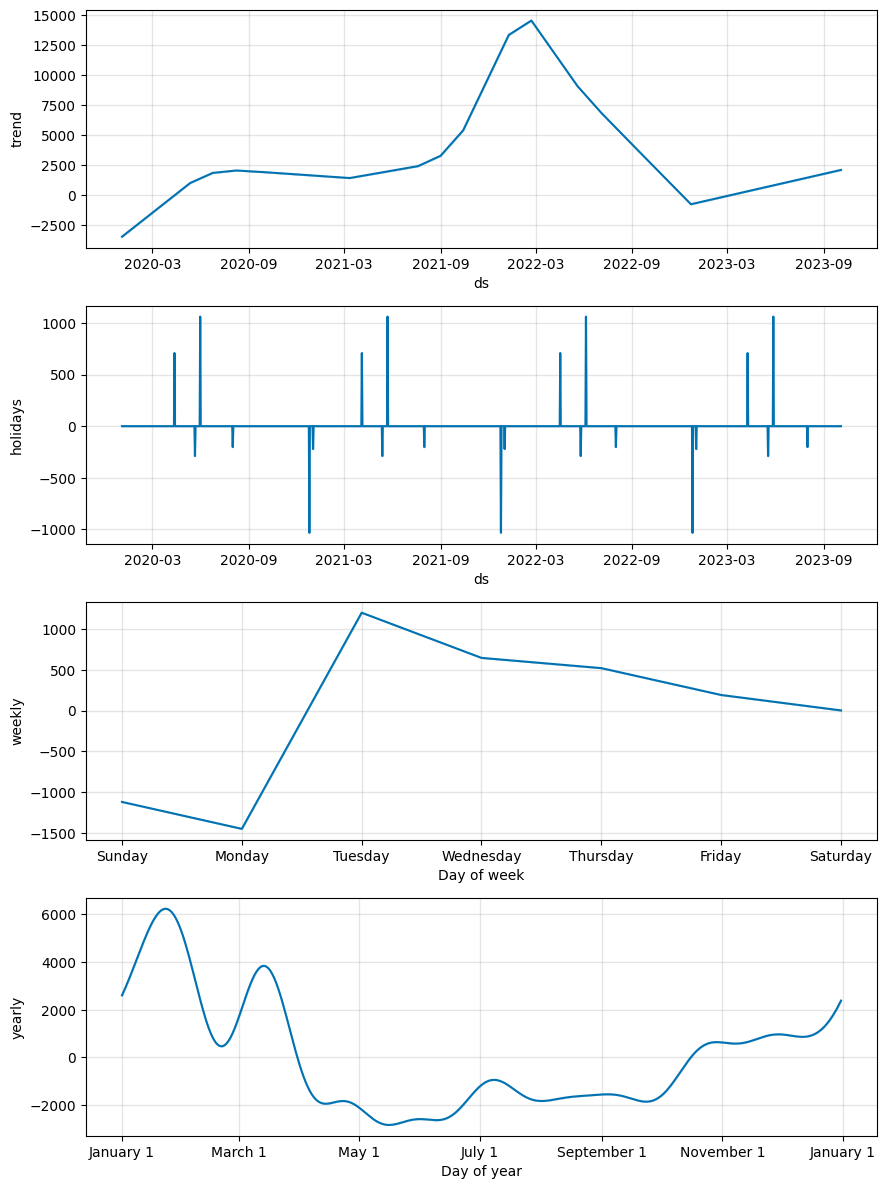

In [12]:
# Python
fig2 = m.plot_components(forecast)

## Adding COVID Lockdown Dates
I want to use the holidays feature of prophet to add important lockdown-related dates of Switzerland. On 3/19/2020, Switzerland imposed a lockdown, which eased on 6/25/2020. 10/01/2020 marks the beginning of another lockdown, which was then eased on 9/13/2021. 2/17/2022 is when all restrictions were lifted. 5/2/2022 is when travel restrictions were lifted. 

I will add these dates as one-off (non-recurring) holidays!

In [66]:
# Python
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-09-21'},
    {'holiday': 'lockdown_3', 'ds': '2021-12-01', 'lower_window': 0, 'ds_upper': '2022-02-17'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-19,0,2020-06-25,98
1,lockdown_2,2020-10-01,0,2021-09-21,355
2,lockdown_3,2021-12-01,0,2022-02-17,78


15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydat

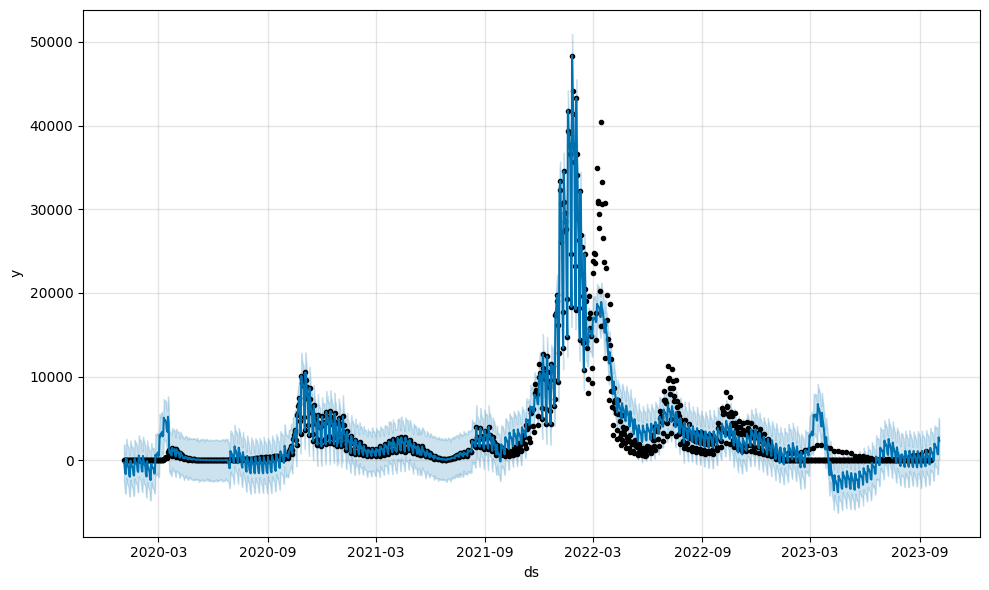

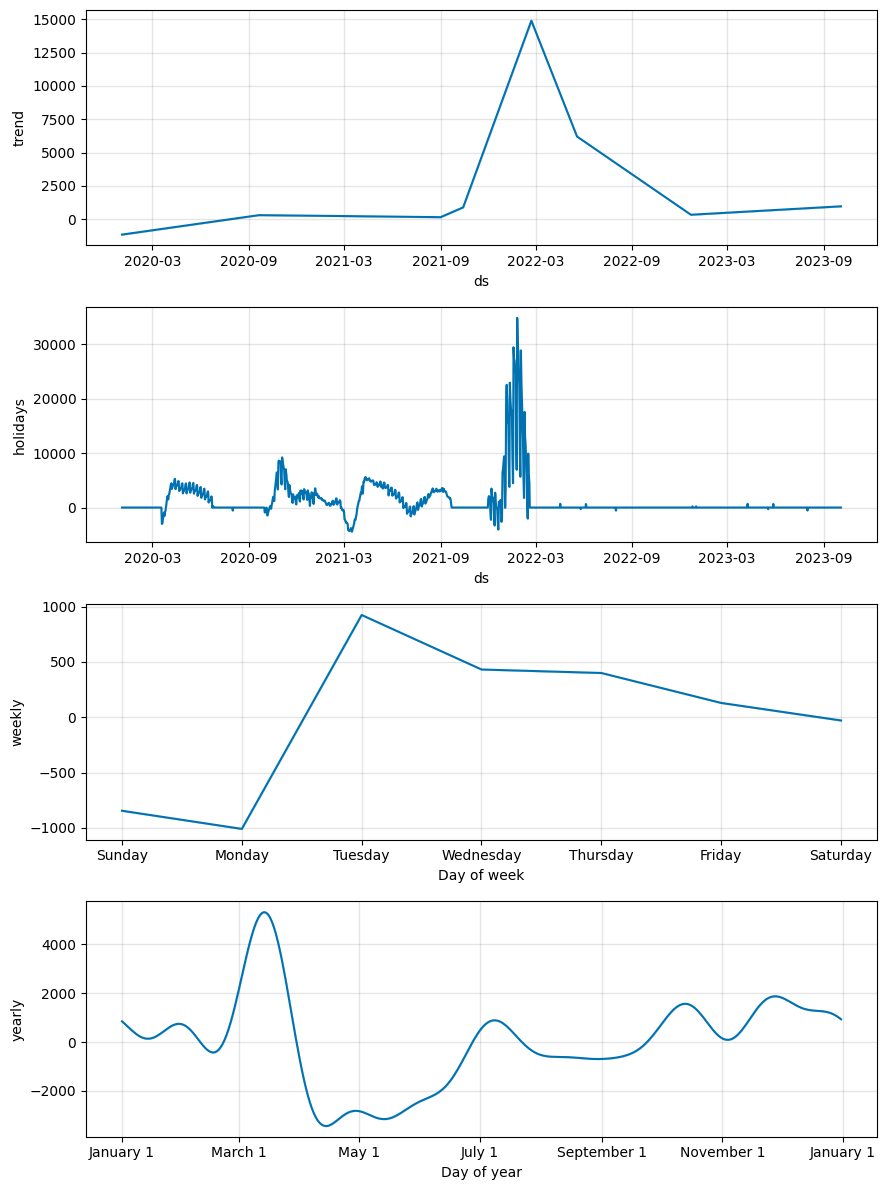

In [67]:
# initialize and fit prophet
m = Prophet(holidays = lockdowns)
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(swiss_data)

# setting future dates
future = m.make_future_dataframe(periods=14)
future.tail()

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot
fig4 = m.plot(forecast)
fig5 = m.plot_components(forecast)
plt.show()

In [68]:
# looking at holiday names
m.train_holiday_names

0        lockdown_1
1        lockdown_2
2        lockdown_3
3    New Year's Day
4     Easter Sunday
5     Ascension Day
6       Whit Sunday
7      National Day
8     Christmas Day
dtype: object

2020-03-19: Initial lockdown kept cases low early 2020.
2020-06-25: Due to these initial good results, regulations gradually eased by Summer 2020.
2020-10-01: There was a small spike during this time, makes sense that regulations increased again.
2021-09-13: Very low number of cases in Sep 2021, so makes sense that regulations were not increased. These lax regulations then lead to the greatest spike in new_cases between Sep 2021 and Sep 2022.
2022-02-17: By Feb 2022, cases have died down, and restrictions are basically fully lifted.

This significantly helped our predictions



## Examining Predictions' Tail

/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of 

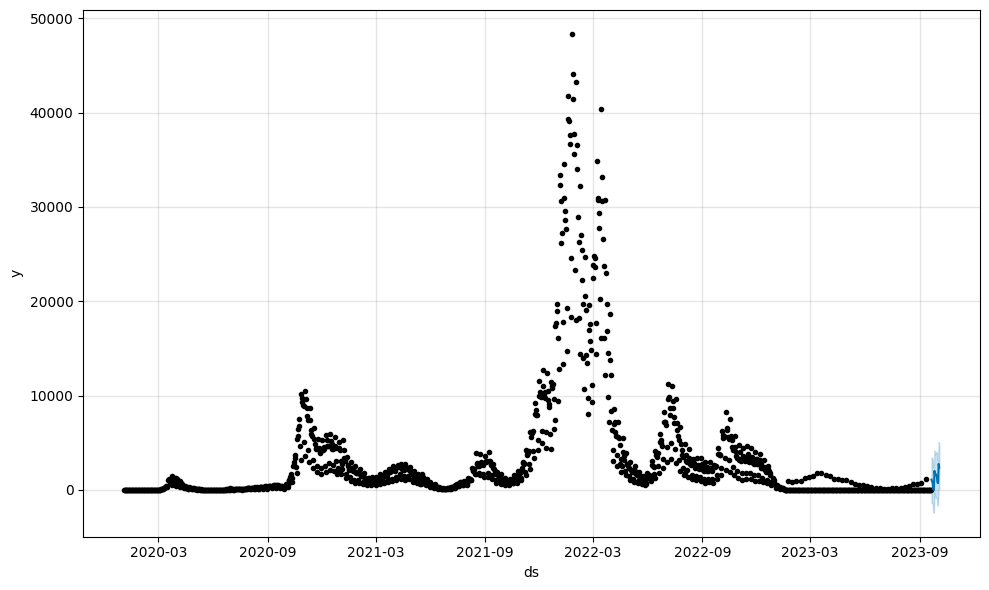

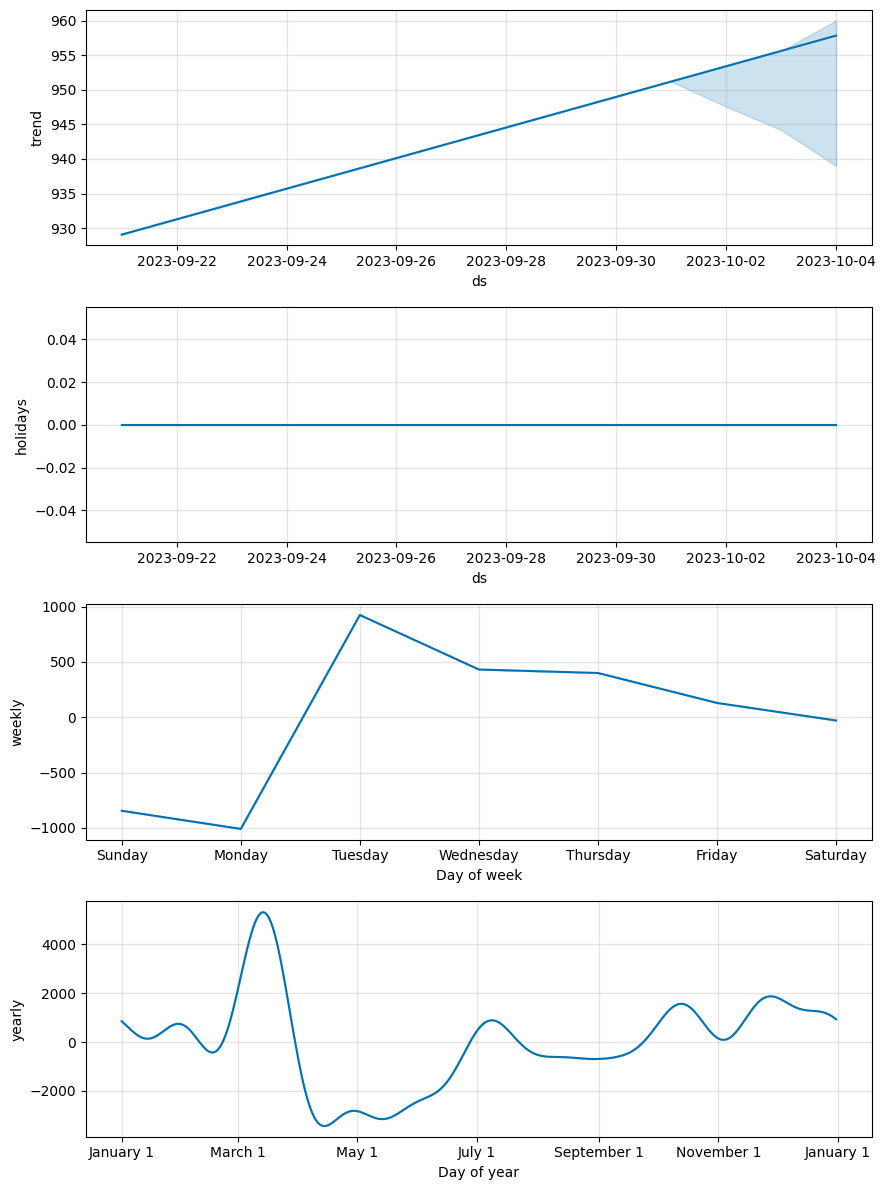

In [69]:
forecast_14_days = forecast.tail(14)
fig3 = m.plot(forecast_14_days)
fig4 = m.plot_components(forecast_14_days)
plt.show()

Very wide prediction interval, so we will remove outliers.

## Removing Outliers

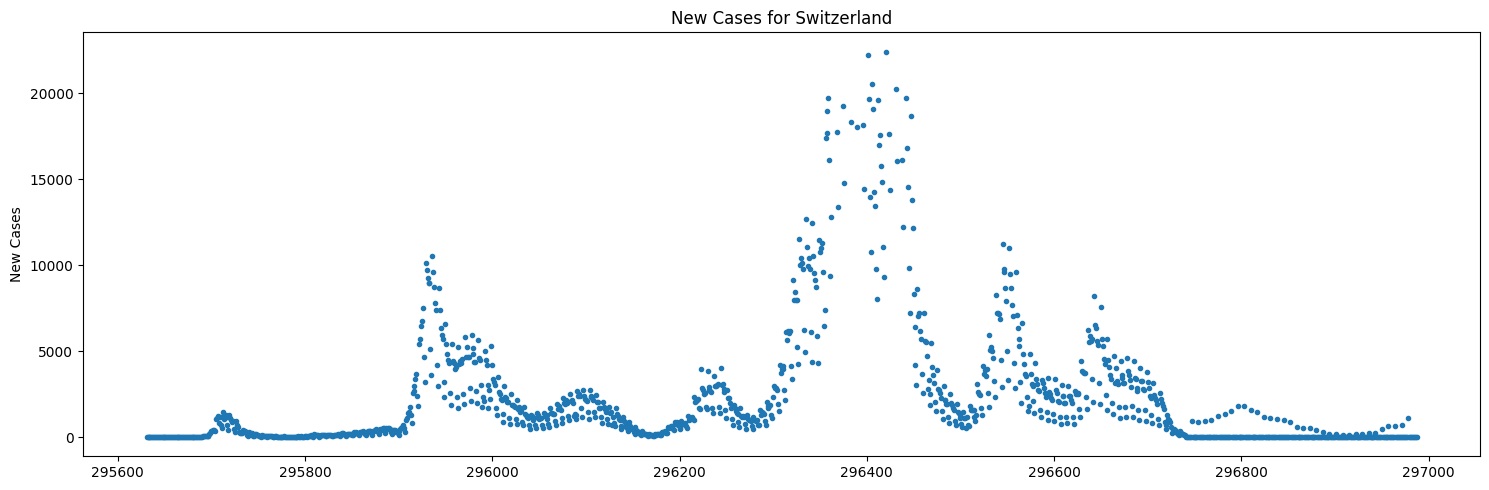

In [70]:
# setting outliers
z_scores = np.abs(stats.zscore(swiss_data['y']))
threshold = 3  # Adjust this threshold as needed
outliers = swiss_data['y'][z_scores > threshold]

# removing outliers
swiss_data_clean = swiss_data[~swiss_data['y'].isin(outliers)]

# examining plot
plt.figure(figsize=(15, 5))
swiss_data_clean['y'].plot(style='.', title=f'New Cases for Switzerland')
plt.ylabel('New Cases')

plt.tight_layout()
plt.show()

## Checking Prophet Again

15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


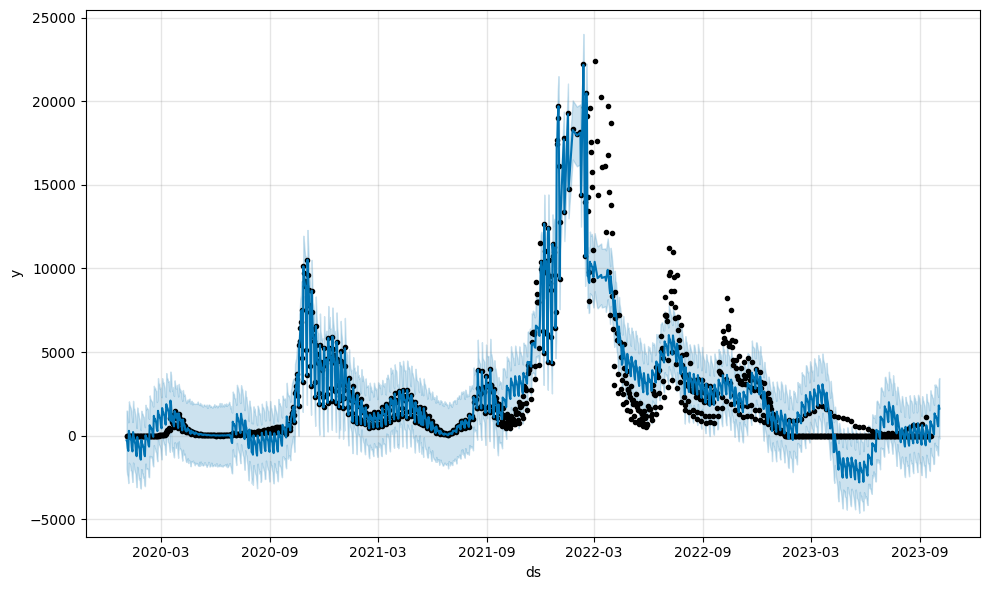

In [71]:
# initialize and fit prophet
# include lockdown dates
m = Prophet(holidays = lockdowns)
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(swiss_data_clean)

# setting future dates
future = m.make_future_dataframe(periods=14)
future.tail()

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# Plot
fig4 = m.plot(forecast)
plt.show()



Removing Outliers did not do too much to help the prediction, I will try examining trend changepoints because our COVID data seems to spike at certain times. 

## Trend Changepoints

### Automatic Changepoint Detection

15:21:26 - cmdstanpy - INFO - Chain [1] start processing
15:21:27 - cmdstanpy - INFO - Chain [1] done processing
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/timhong/Library/Python/3.9/lib/python/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


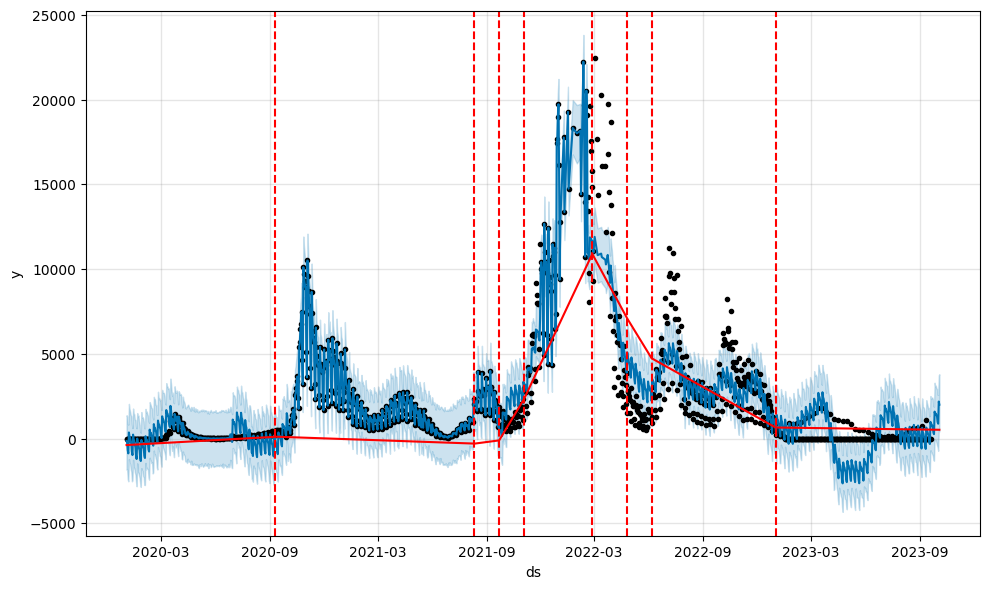

In [72]:
# initialize and fit prophet
m = Prophet(holidays = lockdowns, changepoint_prior_scale=0.08)
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(swiss_data_clean)

# setting future dates
future = m.make_future_dataframe(periods=14)
future.tail()

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


This seems useful, but I want to tune the changepoint CV to find the optimal value of changepoint_prior_scale.

## CV and Tuning Hyperparameters

In [73]:
# initialize and fit prophet
m = Prophet(holidays = lockdowns)
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(swiss_data_clean)

# setting future dates
future = m.make_future_dataframe(periods=14)
future.tail()

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

15:21:51 - cmdstanpy - INFO - Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1319,2023-09-30,1019.665062,-954.690444,2728.933673
1320,2023-10-01,678.332554,-1016.104056,2325.371474
1321,2023-10-02,558.744572,-1201.736929,2318.274394
1322,2023-10-03,1806.836600,77.507255,3652.401933
1323,2023-10-04,1618.265792,-54.538574,3299.476437


In [74]:
# horizon of 14 days
swiss_data_cv = cross_validation(m, initial='730 days', period='180 days', horizon='14 days')
swiss_data_p = performance_metrics(swiss_data_cv)



  0%|          | 0/4 [00:00<?, ?it/s]15:21:56 - cmdstanpy - INFO - Chain [1] start processing
15:21:57 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:02,  1.39it/s]15:21:57 - cmdstanpy - INFO - Chain [1] start processing
15:21:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:01<00:01,  1.03it/s]15:21:58 - cmdstanpy - INFO - Chain [1] start processing
15:21:59 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:03<00:01,  1.22s/it]15:22:00 - cmdstanpy - INFO - Chain [1] start processing
15:22:00 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


In [75]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(swiss_data_clean)  # Fit model with given params
    df_cv = cross_validation(m, horizon='14 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:22:44 - cmdstanpy - INFO - Chain [1] start processing
15:22:44 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
15:22:45 - cmdstanpy - INFO - Chain [1] start processing
15:22:45 - cmdstanpy - INFO - Chain [1] done processing
15:22:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:22:45 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
15:22:45 - cmdstanpy - INFO - Chain [1] start processing
15:22:45 - cmdstanpy - INFO - Chain [1] 

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  3836.666633
1                     0.001                     0.10  3894.068457
2                     0.001                     1.00  3892.267614
3                     0.001                    10.00  3889.653539
4                     0.010                     0.01  3786.412202
5                     0.010                     0.10  3912.355649
6                     0.010                     1.00  3911.045130
7                     0.010                    10.00  3917.498619
8                     0.100                     0.01  3444.472335
9                     0.100                     0.10  3140.690379
10                    0.100                     1.00  3172.826455
11                    0.100                    10.00  3173.417843
12                    0.500                     0.01  3025.978880
13                    0.500                     0.10  2475.745246
14        

15:24:46 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
tuning_results.sort_values(by = 'rmse', ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,rmse
13,0.500,0.10,2475.745246
15,0.500,10.00,2488.659415
14,0.500,1.00,2491.099966
12,0.500,0.01,3025.978880
9,0.100,0.10,3140.690379
10,0.100,1.00,3172.826455
11,0.100,10.00,3173.417843
8,0.100,0.01,3444.472335
4,0.010,0.01,3786.412202
0,0.001,0.01,3836.666633


so we want changepoint_prior_scale = 0.5 and seasonality_prior_scale = 0.1

## Fitting Final Model

In [93]:
# finding last day
swiss_data_clean['ds'].tail(1)

296987    2023-09-20
Name: ds, dtype: object

In [122]:
# split the data into train and test
# setting train end date to 2 weeks before dataset's end date

train_end_date = '2023-09-06'  
train = swiss_data_clean[swiss_data_clean['ds'] <= train_end_date]
test = swiss_data_clean[swiss_data_clean['ds'] > train_end_date]

print(train.shape, test.shape)

(1296, 2) (14, 2)


In [123]:
# initialize and fit prophet - keeping holidays and optimally tuned params
m = Prophet(holidays = lockdowns, changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)
# adding swiss holidays
m.add_country_holidays(country_name='Switzerland')
m.fit(train)

# setting future dates
future = m.make_future_dataframe(periods=14)

# Python predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


test_pred = forecast[forecast['ds'] > train_end_date]
test_pred = test_pred.set_index('ds')

# Extract the actual and forecasted values for the last 14 days (the test period)
# test_pred = forecast[['ds', 'yhat']].tail(14).set_index('ds')


03:40:27 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_23316/2540342817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'])
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_23316/2540342817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


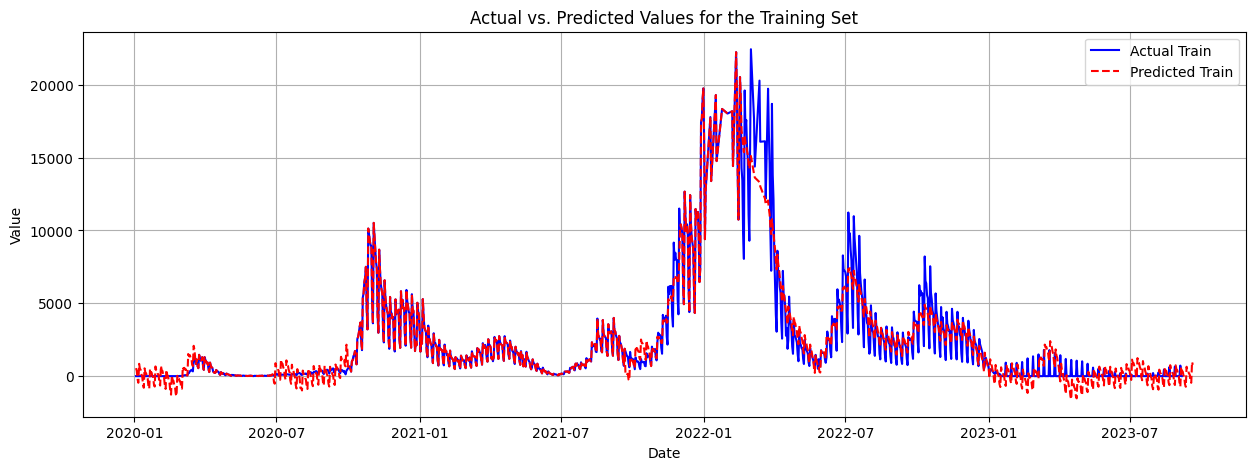

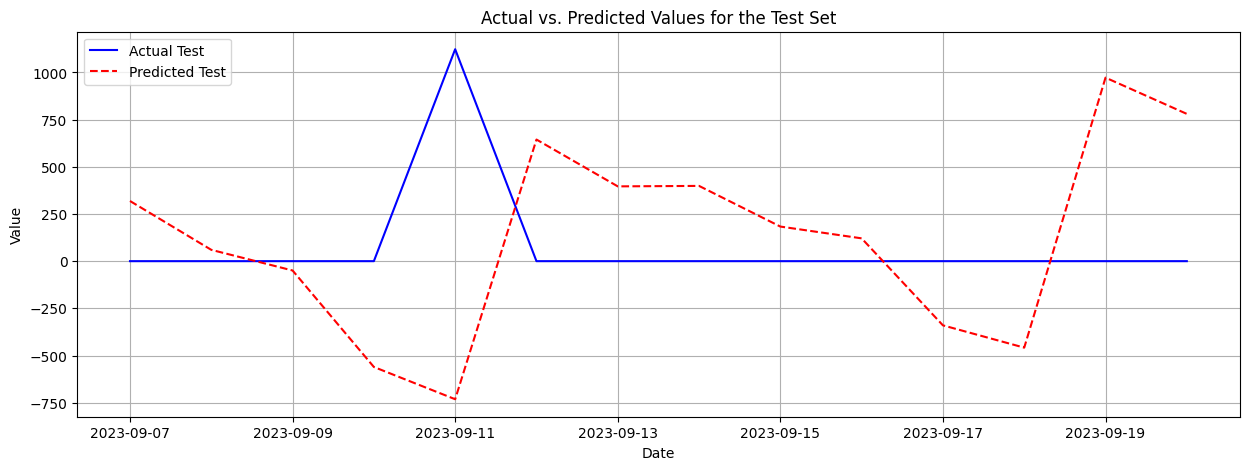

In [125]:
# Assuming 'ds' is a string representing dates, convert it to datetime
train['ds'] = pd.to_datetime(train['ds'])
test['ds'] = pd.to_datetime(test['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot for the training set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label='Actual Train', color='b')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Train', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Actual vs. Predicted Values for the Training Set')
ax.legend()
plt.grid(True)
plt.show()

# Plot for the test set
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test['ds'], test['y'], label='Actual Test', color='b')
ax.plot(forecast['ds'].tail(len(test)), forecast['yhat'].tail(len(test)), label='Predicted Test', color='r', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Actual vs. Predicted Values for the Test Set')
ax.legend()
plt.grid(True)
plt.show()